# Classify Candidate Pairs of Acronyms and Expansions (Assignment 2)

## 1. Import Library

In [2]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


## 2. Prepare Dataset

### 2.1 extract dataset

In [6]:
with tarfile.open("dataacro.tar.gz", "r:gz") as tar:
    tar.extractall("dataacro")

### 2.2 Load dataset

#### 2.2.1 Define extract dataset function

In [8]:
def extract_feature(list_doc):
    X=[]
    y=[]
    for i in range(len(list_doc)):
        lines_feature=list_doc[i].split(" ")[-8:len(list_doc[i])]
        line_label=list_doc[i].split(" ")[-9]
        list_features=[float(line.strip().split(":")[1]) for line in lines_feature]
        list_label=int(line_label) 
        X.append(list_features)
        y.append(list_label)
    
    return X,y  

def extract_text(list_doc):
    X=[]
    y=[]
    for line in list_doc:
        text_feature=line.split(" ")[:-9]
        text_feature=" ".join(text_feature)
        line_label=line.split(" ")[-9]
        
        X.append(text_feature)
        y.append(line_label)
    
    return X

#### 2.2.2 Load and Preprocessing Data

In [9]:


with open("dataacro/trainingset.txt", "r") as file:
    training_lines = file.readlines()

with open("dataacro/testingset.txt", "r") as file:
    testing_lines = file.readlines()

  


X_train,y_train=extract_feature(training_lines)
X_test,y_test=extract_feature(testing_lines)   

X_train=np.array(X_train)
y_train=np.array(y_train)


X_test=np.array(X_test)
y_test=np.array(y_test)

#replace -1 with 0
y_train = np.where(y_train == -1, 0, y_train)
y_test = np.where(y_test == -1, 0, y_test)



X_train_text= extract_text(training_lines)
X_train_text=np.array(X_train_text)
X_train_text=X_train_text.reshape(-1,1)
X_test_text=extract_text(testing_lines)
X_test_text=np.array(X_test_text)
X_test_text=X_test_text.reshape(-1,1)
#check data length
print("Training data length: ", len(X_train))
print("Training data text length: ", len(X_train_text))
print("Training label length: ", len(y_train))
print("Testing data length: ", len(X_test))
print("Testing data text length: ", len(X_test_text))
print("Testing label length: ", len(y_test))


Training data length:  4000
Training data text length:  4000
Training label length:  4000
Testing data length:  1099
Testing data text length:  1099
Testing label length:  1099


In [40]:
col_name = ['F' + str(i+1) for i in range(X_train.shape[1])]

df_train = pd.concat([
    pd.DataFrame(X_train, columns=col_name),
    pd.DataFrame(y_train, columns=['label'])
], axis=1)

print(df_train.head().to_markdown())


|    |       F1 |       F2 |        F3 |   F4 |   F5 |       F6 |   F7 |        F8 |   label |
|---:|---------:|---------:|----------:|-----:|-----:|---------:|-----:|----------:|--------:|
|  0 | 0.918296 | 1        | -0.666667 |  0   | 1    | 0.5      |    0 | 0.39309   |       0 |
|  1 | 1        | 0.5      | -2        |  0   | 0.75 | 0        |    0 | 0.0357143 |       0 |
|  2 | 0.970951 | 1        | -1        |  0.5 | 1    | 0.333333 |    0 | 0.400612  |       0 |
|  3 | 1        | 0.75     | -2        |  0   | 1    | 1        |    1 | 0.392857  |       0 |
|  4 | 0.970951 | 0.666667 | -2.5      |  0   | 1    | 0        |    0 | 0.0196596 |       0 |


In [34]:
col_name = ['Feature text']

df_train_text = pd.concat([
    pd.DataFrame(X_train_text, columns=col_name),
    pd.DataFrame(y_train, columns=['label'])
], axis=1)

print(df_train_text.head().to_markdown())

|    | Feature text                     |   label |
|---:|:---------------------------------|--------:|
|  0 | BUMD=>Usaha Milik                |       0 |
|  1 | TNI=>meminjam senjata dari oknum |       0 |
|  2 | PKI=>Panitia Pengawas            |       0 |
|  3 | MA=>putusan Mahkamah             |       0 |
|  4 | TI=>com Mati body                |       0 |


#### 2.2.3 Dataset Description

In [59]:
print(df_train.describe().to_markdown())  # Ringkasan statistik fitur numerik


|       |           F1 |          F2 |          F3 |          F4 |          F5 |          F6 |          F7 |          F8 |       label |
|:------|-------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|
| count | 4000         | 4000        | 4000        | 4000        | 4000        | 4000        | 4000        | 4000        | 4000        |
| mean  |    0.983223  |    0.847115 |   -0.147867 |    0.538875 |    0.939538 |    0.664874 |    0.503    |    0.618394 |    0.5      |
| std   |    0.0331568 |    0.205513 |    1.21748  |    0.468088 |    0.120776 |    0.375917 |    0.500054 |    0.366575 |    0.500063 |
| min   |    0.619382  |    0.5      |   -4        |    0        |    0.4      |    0        |    0        |   -0.225958 |    0        |
| 25%   |    0.970951  |    0.666667 |   -1.28571  |    0        |    1        |    0.333333 |    0        |    0.257755 |    0        |
| 50%   |    1         |    1        |   

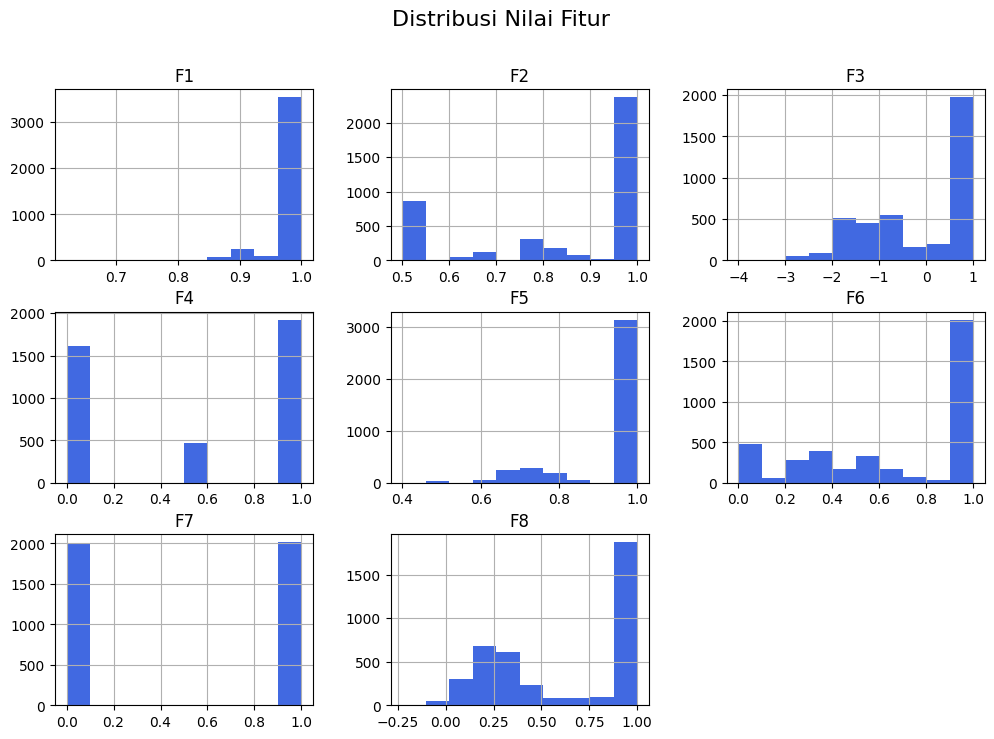

In [58]:
df_train.drop(columns=['label']).hist(figsize=(12, 8), bins=10, color='royalblue')
plt.suptitle("Distribusi Nilai Fitur ", fontsize=16)
plt.show()

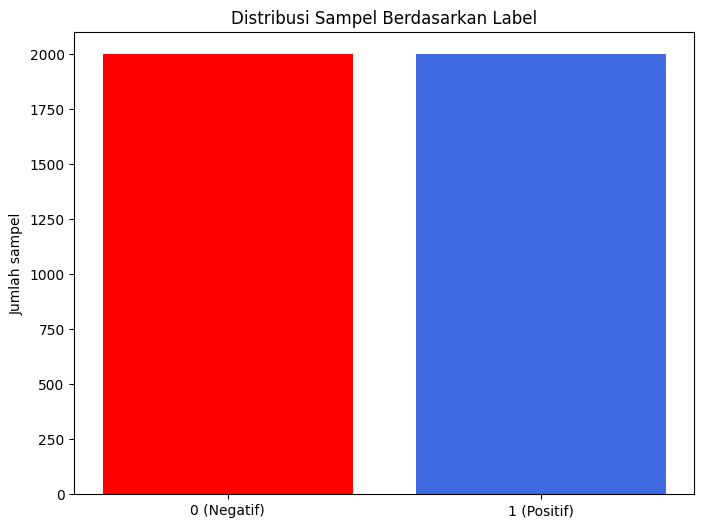

In [57]:
label_count=df_train['label'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Correct way to use bar plot
ax.bar(label_count.index, label_count.values, color=['red', 'royalblue'])  

#ax.set_xlabel("Label")
ax.set_ylabel("Jumlah sampel")
ax.set_title("Distribusi Sampel Berdasarkan Label")
ax.set_xticks([0, 1])  # Explicitly set tick positions
ax.set_xticklabels(["0 (Negatif)", "1 (Positif)"])  # Set tick labels manually
plt.show()

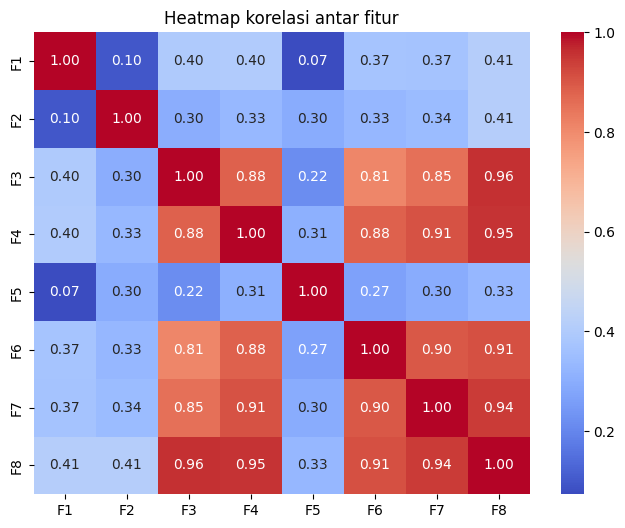

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_train.drop(columns=['label']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap korelasi antar fitur')
plt.show()

## 3. Build Model

In [21]:
eval_model_df=pd.DataFrame()

def input_model_result(df,y_true,y_pred,model_name):
    cm=confusion_matrix(y_true,y_pred)
    pre=precision_score(y_true,y_pred)
    rec=recall_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    
    data={
            'Model':model_name,
            "Confusion Matrix": [cm.tolist()],  # Convert to list to avoid issues
            "Precision": [pre],
            "Recall": [rec],
            "F1-Score": [f1]
        }
    if df.empty:
        df = pd.DataFrame([data])
    else:

        if model_name in df['Model'].values:
            print("Model already exists in the dataframe")
        else:
            df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
        
        print("added new result")
    return df
    

### 3.1 SVM Classifier

In [9]:
svm = SVC(random_state=0)

x = [1.0,10.0,100.0,500.0,1000.0]
y = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
z = [2,3,4]    
parameters=[{'C': x,'kernel': ['linear']},
            {'C': x,'kernel': ['rbf'],'gamma': y} ,
            {'C': x,'kernel': ['poly'],'gamma': y,'degree': z}
           ]
grid=GridSearchCV(estimator = svm,
                        param_grid = parameters,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
grid=grid.fit(X_train,y_train)
svm= grid.best_estimator_
print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

KeyboardInterrupt: 

In [ ]:
y_pred= svm.predict(X_test)
eval_model_df = input_model_result(eval_model_df, y_test, y_pred)


### 3.2 KNN Classifier 

In [26]:
## build model
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(knn, param_grid=param_grid,scoring="recall",cv=cv)
grid.fit(X_train, y_train)

print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

knn = grid.best_estimator_

knn.fit(X_train, y_train)


The best parameters are {'n_neighbors': np.int64(9)} witha score of 0.86


KNeighborsClassifier(n_neighbors=np.int64(9))

In [29]:
y_pred = knn.predict(X_train)
y_true = y_train
eval_model_df = input_model_result(eval_model_df, y_true, y_pred,model_name='knn')
report=classification_report(y_true,y_pred)

Model already exists in the dataframe
added new result


### 3.3 Naive Bayes Classifier 

In [34]:
nb=GaussianNB()
nb.fit(X_train,y_train)


GaussianNB()

In [ ]:
y_pred=nb.predict(X_train)
y_true=y_train

eval_model_df = input_model_result(eval_model_df, y_true, y_pred,model_name='Naive Bayes')


              precision    recall  f1-score   support

          -1       0.96      0.98      0.97      2000
           1       0.98      0.96      0.97      2000

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



### 3.4 Decision Tree

In [38]:
dt=tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [39]:
y_pred=dt.predict(X_test)
y_true=y_test
print(classification_report(y_true,y_pred))

eval_model_df = input_model_result(eval_model_df, y_true, y_pred,model_name='Decision Tree')

              precision    recall  f1-score   support

          -1       0.90      0.99      0.95       500
           1       0.99      0.91      0.95       599

    accuracy                           0.95      1099
   macro avg       0.95      0.95      0.95      1099
weighted avg       0.95      0.95      0.95      1099

added new result


### 3.5 BERT

In [54]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [55]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length, 
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [77]:
# If X_train_text is a NumPy array
if (type(X_train_text) != list):
    X_train_text = X_train_text.tolist()  # Convert numpy array to list

 # Convert to list of strings

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = TextDataset(X_train_text, y_train, tokenizer)
test_dataset = TextDataset(X_test_text, y_test, tokenizer)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",      
    num_train_epochs=3,          
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    warmup_steps=500,            
    weight_decay=0.01,           
    logging_dir="./logs",        
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

bert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

bert.train()

c:\Users\Najwa\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Najwa\AppData\Local\Temp\ipykernel_16068\2187749821.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
print(classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"]))
